In [1]:

#check what version of python you're using - I'm using 3.7.3
from platform import python_version
print(python_version())


# In[3]:

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt


3.7.4


In [2]:
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')

    
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)



In [3]:

# In[21]:
#declaring noise: measured from the RMS of a region of empty sky while opening the image in DS9
#these are newly taken from the HH 6 images...
# noise_126 = 0.0465246
# noise_128 = 0.04733
# noise_164 = 0.0561296

#from the regridded images...
noise_126 = 0.216037
noise_128 = 0.258513
noise_164 = 0.39321
noise_halpha = 0.302712
#converting units for reference
#hdu1_conv_scaled = hdu1_conv_scaled * hdu1_fnu / 1e6 #converting to MJy
#hdu1_conv_scaled = hdu1_conv_scaled / hdu1_pix**2. * 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec



#EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
#set your path to some directory with images (the images can be in subdirectories)
#using ** will grab all files even in subdirectories...WARNING this will take longer
path = '../../../ngc1333_fits/'
im_names_hub_dash = im_name_finder(path+'*', 'fit')
im_names_hub_dash = [i.replace('\\', '/') for i in im_names_hub_dash]
im_names_hub = [path+'126_image.fits', path+'128_image.fits', path+'164_image.fits', path+'halph_hart_image.fits']


# In[28]:

#Minimal loop through all the images, including a try/except in case an image is faulty for whatever reason
#IMPORTANT: A more detailed example between two single images is at the end of this code with many more comments

#First, we need to setup the image we're projecting ONTO
#This will be the same no matter the loop, so only need to do this once
#low_res = [x for x in im_names_spitz if 'n1333_lh_3_SiII_' in x][0]  #finding the lowest res image - LH and long lambda, so [SiII]

#126
#hdu1 = fits.open(low_res)[0]
low_res = im_names_hub_dash[0]   #Could also let this be a hubble image...if so, see the hubble loop below for how to setup grabbing the data, header, pixel conversion from the hdu
hdu1 = fits.open(low_res)

#hdu1_pix = hdu1.header['CDELT2'] #the pixel size in degrees, CDELT is the keyword for Spitzer images
#hdu1_pix_torad = hdu1_pix * np.pi / 180.
hdu1_pix = hdu1[0].header['D001SCAL'] #pixel size in arcsecs, but D001SCAL is the keyword for Hubble images
hdu1_pix_torad = hdu1_pix / 206265.
hdu1_fnu = hdu1[0].header['PHOTFNU']

low_res = im_names_hub[0]
hdu1 = fits.open(low_res)
hdu1_data = hdu1[0].data
hdu1_header = hdu1[0].header

#converting noise units
noise_126 = noise_126 * hdu1_fnu / 1e6


#128
name = im_names_hub_dash[2]   #Could also let this be a hubble image...if so, see the hubble loop below for how to setup grabbing the data, header, pixel conversion from the hdu
hdu2 = fits.open(name)

#reading in data
hdu2_pix = hdu2[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
hdu2_pix_torad = hdu2_pix / 206265.
hdu2_fnu = hdu2[0].header['PHOTFNU']
hdu2_bw = hdu2[0].header['PHOTBW']


#now working with long exposure image (necessary for working with data based on header)
name = im_names_hub[1]
hdu2 = fits.open(name)
hdu2_data = hdu2[0].data
hdu2_header = hdu2[0].header

#converting noise units
noise_128 = noise_128 * hdu2_fnu / 1e6


SystemExit: 

C:\Users\Adam2\Anaconda\envs\mypython3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


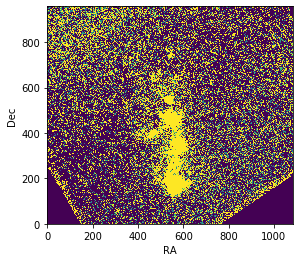

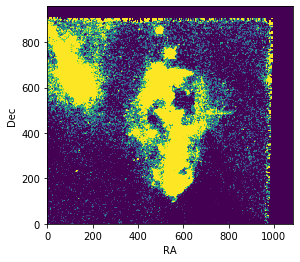

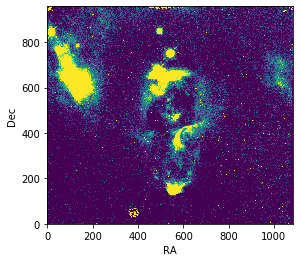

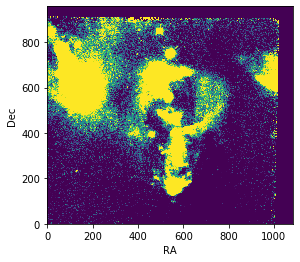

In [4]:
for name2 in [im_names_hub[3]]:
    #halpha
    #need to do halpha image as well...
    hdu3 = fits.open(im_names_hub_dash[6])

    #reading in data
    hdu3_pix = hdu3[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
    hdu3_pix_torad = hdu3_pix / 206265.

    #under science header of the original image
    hdu3_fnu = hdu3[1].header['PHOTFNU']
    hdu3_bw = hdu3[1].header['PHOTBW']
    
    #opening the regridded image?
    hdu3 = fits.open(name2)
    hdu3_data = hdu3[0].data
    hdu3_header = hdu3[0].header
    
    #converting noise units
    noise_halpha = noise_halpha * hdu3_fnu / 1e6
    
    
    
    #halpha
    #need to do halpha image as well...
    hdu4 = fits.open(im_names_hub_dash[6])

    #reading in data
    hdu4_pix = hdu4[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
    hdu4_pix_torad = hdu4_pix / 206265.

    #under science header of the original image
    hdu4_fnu = hdu4[1].header['PHOTFNU']
    hdu4_bw = hdu4[1].header['PHOTBW']
    
    #opening the regridded image?
    name3 = im_names_hub[2]
    hdu4 = fits.open(name3)
    hdu4_data = hdu4[0].data
    hdu4_header = hdu4[0].header
    
    #converting noise units
    noise_164 = noise_164 * hdu1_fnu / 1e6

    

    #reprojection of one hdu using the header (coords and pixels) of another
    #The first input is the path to the file we're reprojecting. The second input is the header of the image we're projecting ONTO
    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header

    #file_start = 'Convolved_Images_Hub/conv_'
    #conv2_path = file_start + name.split('/')[-1]

    #FeII 1.26
    w = WCS(hdu1_header)
    wcs_header = w.to_header()
    file_start = '../../Convolved_Images_Hub/conv_unitsfix_'
    hdu1_conv = fits.open(file_start + low_res.split('/')[-1])
    hdu1_conv_scaled = hdu1_conv[0].data #* hdu1_pix**2. / 4.25e10
    
    #hbeta, 1.28
     #para is False for large images (like these hubble ones)
    #output is array (a 2D array of data) and footprint (the footprint from the analysis)
    file_start = '../../Regridded_Hub/regrid_unitsfix_'
    hdu_regrid_hub = fits.open(file_start + name.split('/')[-1])
    array = hdu_regrid_hub[0].data #* hdu2_pix**2. / 4.25e10   
    
    #halpha, 0.656
    hdu_regrid_hub2 = fits.open(file_start + name2.split('/')[-1])
    array2 = hdu_regrid_hub2[0].data #* hdu3_pix**2. / 4.25e10

    #halpha, 1.64
    hdu_regrid_hub3 = fits.open(file_start + name3.split('/')[-1])
    array3 = hdu_regrid_hub3[0].data #* hdu4_pix**2. / 4.25e10

    
    
    #now that we have a reprojected hubble image for hdu2 and both are convolved, need to
    #divide one by the other...then can use the same wcs header that we projected onto (hdu1's)!
    #getting rid of nan values
    where_are_NaNs = np.isnan(array)
    array[where_are_NaNs] = 0.

    where_are_NaNs = np.isnan(array2)
    array2[where_are_NaNs] = 0.

    where_are_NaNs = np.isnan(array3)
    array3[where_are_NaNs] = 0.

    where_are_NaNs = np.isnan(hdu1_conv_scaled)
    hdu1_conv_scaled[where_are_NaNs] = 0.

    #print(perc * np.max(array))
    #array[array < (perc * np.max(array))] = 0.  #only taking values greater than some percent of the maximum

    #scaling by the signal to noise
    perc = 0.2 #this tends to work?? Maybe can change...
    perc2 = 0.2
    
    array[array < noise_128*perc] = 0.
    array2[array2 < noise_halpha*perc2] = 0.
    array3[array3 < noise_164*perc2] = 0.
    hdu1_conv_scaled[hdu1_conv_scaled < noise_126*perc] = 0.

    #getting rid of 0 values
    array[array < 0.] = 0.
    array2[array2 < 0.] = 0.
    array3[array3 < 0.] = 0.
    hdu1_conv_scaled[hdu1_conv_scaled < 0.] = 0.

    
   
    #cutting out part of the image...HH 10 or HH 7 in order to make scattered light image
    #purpose is to find max of the region to use to normalize the image
#     count = 0
#     hh10_max = []
#     coords = [(560, 460), (13, 13)] #these coordinates worked before...hopefully works again?
#     coords = [(556, 136), (15, 15)] #hh7, 556,135 and 8, 25
#     coords = [(535, 546), (10, 10)] #hh11
    
    flux01 = array  #*1e6*1e-23*hdu2_bw #normalizing to max and converting units to lam*flam #hdu1_conv_scaled - eps * array
    flux02 = array2  #*1e6*1e-23*hdu3_bw #normalizing to max and converting units to nu*fnu
#     data_subtrac = flux01 - flux02
#     data_subtrac = (array - array.min()) / (array.max() - array.min())  - (array2 - array2.min()) / (array2.max() - array2.min())
#     data_ratio = np.divide(flux01, flux02, out=np.zeros_like(flux02), where=flux02!=0.) #need to do np.divide to guarantee we get no divide by zero issue...

    #plotting image to check
    #order is halpha, 1.26, 1.28, 1.64...
    implot(array2, w, False, np.mean(array2))
    implot(hdu1_conv_scaled, w, False, np.mean(hdu1_conv_scaled)) 
    implot(array, w, False, np.mean(array)) 
    implot(array3, w, False, np.mean(array3)) 
    
    # remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
#     w = WCS(hdu2_header)
#     wcs_header = w.to_header()
#     save_path = './'  #See fits_saver's "save_path" description for explanation
#     fits_saver(data_subtrac, wcs_header, 'hub_noleakage_imscatt__ston_'+str(perc)+'_scale3.fits', save_path)  #saving the reprojected image
sys.exit()

[4.23598533e-12 1.06349404e-11 7.84537126e-12 2.15214085e-11]
[637.04635999  60.79743164  60.79743164 637.04635999]
continuum intensity:  [2.95106243e-11 2.00828618e-11 1.43557269e-11 2.39891369e-11]
blackbody fit:  [3.56578721e+03 1.36161449e-23]
1 sigma:  [5.23493103e+02 9.43903759e-24]
curve_fit attempt:  [-1.97416054e-23  5.23938071e+00  8.62153822e-11  6.25492719e-11]
0.725500141469512
sum(squared diffs):  4.607205358862025e-23
non-linear attempt:  [-2.13432356e-23  5.23938223e+00  8.83746843e-11  6.39434031e-11]
fit intensities:  [2.95455504e-11 2.44063582e-11 1.50818024e-11 1.87619433e-11]
sum(squared diffs):  4.6544579360523544e-23
0.7235488710141612


Text(0, 0.5, '$\\rm Intensity$ (W/m^3/sr)')

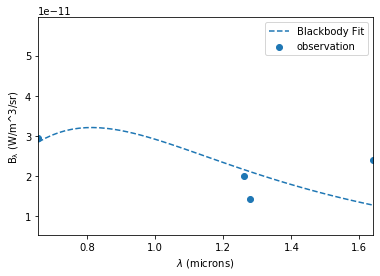

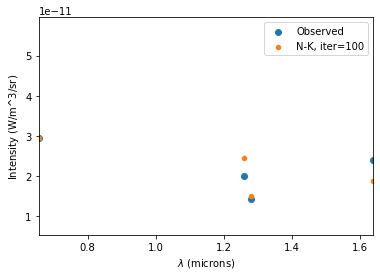

In [14]:
'''
Using 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton_krylov.html#scipy.optimize.newton_krylovfor a non linear solver…

Try the algebraic solution… open up 4 images, 
put cursorover same place, see what values are…

Halpha of 12*.3 (can reduce to reduce negative amt)
1.2six of 1.3
Pabeta of 1.2  
1.six4 of 3

Q: How long it takes to 12k iterations?
That’s at me…See how long it takes on my computer 
vs. Inanna…fora bounded single pixel problem…

'''

#ordering arrays by wavelength...
#     implot(array2, w, False, np.mean(array2))
#     implot(hdu1_conv_scaled, w, False, np.mean(hdu1_conv_scaled)) 
#     implot(array, w, False, np.mean(array)) 
#     implot(array3, w, False, np.mean(array3)) 

cen_x = 690 # 580
cen_y = 440 # 370
del_x = 1 #200 # 55
del_y = 1 #150 #100

# #HH9? The arcy feature thing
cutout1 = Cutout2D(array2, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut1 = cutout1.data
wcscut1 = cutout1.wcs 

cutout2 = Cutout2D(hdu1_conv_scaled, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut2 = cutout2.data
wcscut2 = cutout2.wcs 

cutout3 = Cutout2D(array, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut3 = cutout3.data
wcscut3 = cutout3.wcs 

cutout4 = Cutout2D(array3, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut4 = cutout4.data
wcscut4 = cutout4.wcs 

#plotting cutouts
# implot(datacut1, wcscut1, False, (datacut1)) 
# implot(datacut2, wcscut2, False, (datacut2)) 
# implot(datacut3, wcscut3, False, (datacut3)) 
# implot(datacut4, wcscut4, False, (datacut4)) 



#global vars for func
h = 6.626e-34 #SI units, J*sec
c = 2.998e8 #SI units, m/s
k_B = 1.38e-23 #SI, J/K

#list of wavelengths for each filter being used
lam_arr = 1e-6 * np.array([0.656, 1.26, 1.28, 1.64])

#func for planck's law
def B_lam(lam, temp=1000, const =1e5):
    return const * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)


#continuum of filament fluxes near hh 8
cont_flux = np.array([np.mean(datacut1), np.mean(datacut2), np.mean(datacut3), np.mean(datacut4)] )
print(cont_flux)
# cont_flux = np.array([np.max(datacut1), np.max(datacut2), np.max(datacut3), np.max(datacut4)] )

#to convert from MJy to MJy / sr
sr_convert = 1. / np.array([hdu3_pix**2., hdu1_pix**2., hdu2_pix**2., hdu4_pix**2.])
#to convert from MJy to W/m^2/Hz
jy_to_si = 1e-26 * 1e6
#convert contflux
cont_flux = cont_flux * jy_to_si #* sr_convert
print(sr_convert)
print('continuum intensity: ', c / lam_arr**2. * cont_flux)



#attempting many solvers
from scipy.optimize import newton_krylov
from scipy.optimize import minimize
from scipy.optimize import curve_fit
# xin = [500, 4.105e12] #K, const...initial guesses
xin = [2.44402408e03, 2.56589326e-12]
popt, pcov = curve_fit(B_lam, lam_arr, c / lam_arr**2. * cont_flux, p0=xin) #solving!
print('blackbody fit: ', popt) #output
perr = np.sqrt(np.diag(pcov))
print('1 sigma: ', perr)


#plotting
plt.figure(212) #establish new figure
#plot to show results
plt.scatter(1e6*lam_arr, c / lam_arr**2. * cont_flux, label = 'observation') #the data

#plotting planck's law with fit params
lam_interp = np.linspace(lam_arr[0], lam_arr[-1])
plt.plot(1e6*lam_interp, B_lam(lam_interp, popt[0], popt[1]), linestyle='--', label = 'Blackbody Fit')

#formatting
plt.legend(loc='best')
plt.ylim(min(c / lam_arr**2. * cont_flux) - 9e-12, max(c / lam_arr**2. * cont_flux) + 3e-11)
plt.xlim(1e6*lam_arr[0], 1e6*lam_arr[-1])
plt.xlabel(r'$\lambda$ (microns)')
plt.ylabel(r'$\rm {B}_{\lambda}$ (W/m^3/sr)')



#global vars for func
R_Fe = 2.0
R_H = 17.5
y_arr = [0.47245, 0.77307, 0.78015, 0.85001]
T = popt[0]

#func for non-linear equation...
def scatt_func(lam_arr, C, A_V, f_H, f_Fe):
    return np.array([
        (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V, 
        (R_Fe * f_Fe + B_lam(lam_arr[1], T, C)) * y_arr[1]**A_V,
        (f_H + B_lam(lam_arr[2], T, C)) * y_arr[2]**A_V,
        (f_Fe + B_lam(lam_arr[3], T, C)) * y_arr[3]**A_V 
        ])

#attempting to fit using curve_fit
xin = [1e-23, 5, 1e-11, 1e-11]
popt, pcov = curve_fit(scatt_func, lam_arr, c / lam_arr**2. * cont_flux, p0=xin) #solving!
print('curve_fit attempt: ', popt)

C_fit, A_V_fit, f_H_fit, f_Fe_fit = popt
# extinc_factor = y_arr**A_V
print(f_Fe_fit / f_H_fit)

#chi^2 test...against curve_fit
obs_intens = c / lam_arr**2. * cont_flux
theory_intens = scatt_func(lam_arr, C_fit, A_V_fit, f_H_fit, f_Fe_fit)
n_obs = len(obs_intens)
chi2 = np.sum((obs_intens - theory_intens)**2.)
print('sum(squared diffs): ', chi2)



#setting up a figure to plot on these fits...
plt.figure(213) #establish new figure
#plot to show results
plt.scatter(1e6*lam_arr, c / lam_arr**2. * cont_flux, label = 'Observed') #the data
# plt.scatter(1e6*lam_arr, scatt_func(lam_arr, C_fit, A_V_fit, f_H_fit, f_Fe_fit), label = 'Curve_Fit', s=20) #curve_fit method




#redefining function to setup a system of equations equal to 0 
def scatt_equ_solver(input_arr):
    C, A_V, f_H, f_Fe = input_arr
    equ_sys = c / lam_arr**2. * cont_flux - np.array([
        (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V, 
        (R_Fe * f_Fe + B_lam(lam_arr[1], T, C)) * y_arr[1]**A_V,
        (f_H + B_lam(lam_arr[2], T, C)) * y_arr[2]**A_V,
        (f_Fe + B_lam(lam_arr[3], T, C)) * y_arr[3]**A_V 
        ])
#     print(equ_sys)
    return equ_sys

#trying to solve system with non-lin solver
from scipy.optimize import newton_krylov
from scipy.optimize import anderson
from scipy.optimize import broyden1
from scipy.optimize import broyden2
xin1 = [-1.97416054e-23,  5.23938071,  8.62153822e-11,  6.25492719e-11] #initial guess
xin2 = [2e-23, 5.2, 9e-11, 6.3e-11] #initial guess
xin3 = [2e-22, 2, 5e-11, 5e-11] #initial guess
xin4 = [1e-10, 5, 1e-5, 1e-5] #initial guess
xin5 = [2e-23, 10, 1e-12, 1e-12] #initial guess
xin_list = [xin1, xin2, xin3, xin4, xin5]

'''
Notes from testing newton-krylov...of possible methods one can adjust
#default: max iter can be 30-100, step can be 1e-10 to 1e-14
#for all except cgs, can use iter of 10,000 or 100,000\
#for cgs can use 5000
#that said, cgs isn't great, gmres and bicgstab seem best
#min f_tol = 4.95e-12...maxiter with bicgstab can go up to say 100000...seems to level off at about 300 to 1000? checking...
'''
met = ['lgmres', 'gmres', 'bicgstab', 'cgs', 'minres']
k = met[2]

#loop testing different numbers of iterations
iter_list = [1, 5, 10, 100, 200]
# for i in [1, 5, 10, 100, 200]:
i = 100
# for j in range(len(xin_list)):
#     for k in met:
#         try:
#             print('loop: ', i, k)
solved = newton_krylov(scatt_equ_solver, xin_list[0], iter = i, method=k) #non-lin solver
# solved = anderson(scatt_equ_solver, xin_list[0], f_tol=9e-12) #non-lin solver
# solved = broyden1(scatt_equ_solver, xin_list[-1], f_tol=1e-11) #non-lin solver
# solved = broyden2(scatt_equ_solver, xin_list[0], iter = i) #non-lin solver

print('non-linear attempt: ', solved)

#separating fit into diff variables...calculating a sum of squared diffs
C_nk, A_V_nk, f_H_nk, f_Fe_nk = solved
print('fit intensities: ', scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk))
#calculating sum of squared diffs...against newton-krylov
theory_intens = scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk)
chi2 = np.sum((obs_intens - theory_intens)**2.)
print('sum(squared diffs): ', chi2)

# extinc_factor = y_arr**A_V
print(f_Fe_nk / f_H_nk)
#"sanity check" for founds on Fe/H


#check how much time this took
# stop = timeit.default_timer()
# print('Time: ', stop - start)  


#plotting non-linear fit to intensity
# lam_interp = np.linspace(lam_arr[0], lam_arr[-1])
plt.scatter(1e6*lam_arr, scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk), label = 'N-K, iter='+str(i), s=20)
#             print('success')
#         except: 
#             print('error')

#         print('RESET')
#formatting our plot
plt.legend(loc='best')
plt.ylim(min(c / lam_arr**2. * cont_flux) - 9e-12, max(c / lam_arr**2. * cont_flux) + 3e-11)
plt.xlim(1e6*lam_arr[0], 1e6*lam_arr[-1])
plt.xlabel(r'$\lambda$ (microns)')
plt.ylabel(r'$\rm Intensity$ (W/m^3/sr)')

non-linear attempt:  [-3.92228753e-23  5.65802773e+00  1.22455752e-10  8.37374631e-11]
fit intensities:  [2.96202633e-11 2.45257067e-11 1.51743057e-11 1.87453368e-11]
sum(squared diffs):  4.791840236511488e-23


Text(0, 0.5, '$\\rm Intensity$ (W/m^3/sr)')

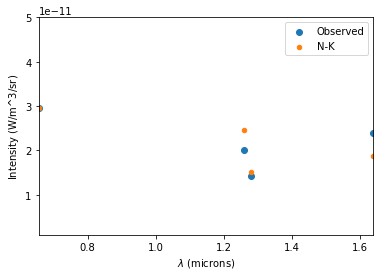

In [8]:
xin = [1.97416054e-23,  5.23938071,  8.62153822e-11,  6.25492719e-11] #result from curve_fit
xin = [1.684E-23, 5.000, 3.174E-11, 2.329E-11] #result from default tester
# xin = [-1.14964844e-23,  4.91891410,  6.89021847e-11,  5.22945372e-11] #plugging back fit from code into code
# xin = [-1.32359021e-23,  5.00547418,  7.09386516e-11,  5.52949364e-11] #from using default tester result and iter = 1000
xin = [-1.14964844e-13,  6,  1.89021847e-10,  1.22945372e-10]
# [-3.92228753e-23  5.65802773e+00  1.22455752e-10  8.37374631e-11] #set resulting from the above parameters
# xin = [-3.92228753e-23,  6,  1.89021847e-10,  1.22945372e-10]

solved = newton_krylov(scatt_equ_solver, xin, iter = 1000, method='bicgstab') #non-lin solver
C_nk, A_V_nk, f_H_nk, f_Fe_nk = solved
print('non-linear attempt: ', solved)
print('fit intensities: ', scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk))
#calculating sum of squared diffs...against newton-krylov
theory_intens = scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk)
chi2 = np.sum((obs_intens - theory_intens)**2.)
print('sum(squared diffs): ', chi2)

#setting up a figure to plot on these fits...
plt.figure(213) #establish new figure
#plot to show results
plt.scatter(1e6*lam_arr, c / lam_arr**2. * cont_flux, label = 'Observed') #the data
# plt.scatter(1e6*lam_arr, scatt_func(lam_arr, C_fit, A_V_fit, f_H_fit, f_Fe_fit), label = 'Curve_Fit', s=20) #curve_fit method

#plotting non-linear fit to intensity
# lam_interp = np.linspace(lam_arr[0], lam_arr[-1])
plt.scatter(1e6*lam_arr, scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk), label = 'N-K', s=20)
#             print('success')
#         except: 
#             print('error')

#         print('RESET')
#formatting our plot
plt.legend(loc='best')
plt.ylim(1e-12, 5e-11)
plt.xlim(1e6*lam_arr[0], 1e6*lam_arr[-1])
plt.xlabel(r'$\lambda$ (microns)')
plt.ylabel(r'$\rm Intensity$ (W/m^3/sr)')

[9.96451899e-12 1.17624171e-11 7.69761530e-12 2.27367671e-11]
[637.04635999  60.79743164  60.79743164 637.04635999]
continuum intensity:  [6.94193094e-11 2.22119718e-11 1.40853581e-11 2.53438532e-11]
blackbody fit:  [5.09903288e+03 5.13022565e-24]
1 sigma:  [1.00745090e+03 4.12031581e-24]
curve_fit attempt:  [-2.29099942e-22  7.22270364e+00  1.06816911e-09  5.82845407e-10]
0.5456490001124173
sum(squared diffs):  2.3491096084794688e-51
non-linear attempt:  [-2.29099942e-22  7.22270364e+00  1.06816911e-09  5.82845407e-10]
fit intensities:  [6.94193094e-11 2.22119718e-11 1.40853581e-11 2.53438532e-11]
sum(squared diffs):  2.3491096084794688e-51
0.5456490001124173


Text(0, 0.5, '$\\rm Intensity$ (W/m^3/sr)')

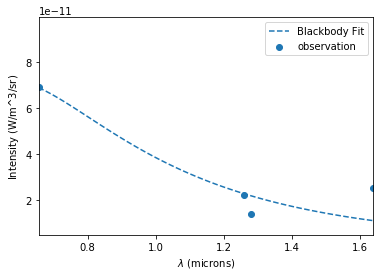

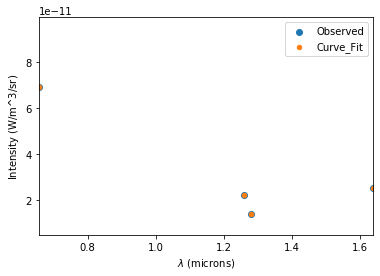

In [26]:
'''
Using 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton_krylov.html#scipy.optimize.newton_krylovfor a non linear solver…

Try the algebraic solution… open up 4 images, 
put cursorover same place, see what values are…

Halpha of 12*.3 (can reduce to reduce negative amt)
1.2six of 1.3
Pabeta of 1.2  
1.six4 of 3

Q: How long it takes to 12k iterations?
That’s at me…See how long it takes on my computer 
vs. Inanna…fora bounded single pixel problem…

'''

#ordering arrays by wavelength...
#     implot(array2, w, False, np.mean(array2))
#     implot(hdu1_conv_scaled, w, False, np.mean(hdu1_conv_scaled)) 
#     implot(array, w, False, np.mean(array)) 
#     implot(array3, w, False, np.mean(array3)) 

#close but no cigar
# cen_x = 690 # 580
# cen_y = 440 # 370
# del_x = 1 # 55
# del_y = 1 #100

# #perfect!
# cen_x = 690+1 # 580
# cen_y = 440+1 # 370
# del_x = 1 # 55
# del_y = 1 #100

# #perfect!
cen_x = 690-1 # 580
cen_y = 440+1 # 370
del_x = 1 # 55
del_y = 1 #100

# #perfect!
# cen_x = 690+25 # 580
# cen_y = 440+35 # 370
# del_x = 1 # 55
# del_y = 1 #100

# #perfect!
# cen_x = 690-50 # 580
# cen_y = 440-30 # 370
# del_x = 1 # 55
# del_y = 1 #100

# #perfect!
# cen_x = 690+25 # 580
# cen_y = 440+60 # 370
# del_x = 1 # 55
# del_y = 1 #100

# #perfect!
# cen_x = 690-25 # 580
# cen_y = 440+75 # 370
# del_x = 1 # 55
# del_y = 1 #100

# #HH9? The arcy feature thing
cutout1 = Cutout2D(array2, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut1 = cutout1.data
wcscut1 = cutout1.wcs 

cutout2 = Cutout2D(hdu1_conv_scaled, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut2 = cutout2.data
wcscut2 = cutout2.wcs 

cutout3 = Cutout2D(array, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut3 = cutout3.data
wcscut3 = cutout3.wcs 

cutout4 = Cutout2D(array3, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut4 = cutout4.data
wcscut4 = cutout4.wcs 

#plotting cutouts
# implot(datacut1, wcscut1, False, np.mean(datacut1)) 
# implot(datacut2, wcscut2, False, np.mean(datacut2)) 
# implot(datacut3, wcscut3, False, np.mean(datacut3)) 
# implot(datacut4, wcscut4, False, np.mean(datacut4)) 


#global vars for func
h = 6.626e-34 #SI units, J*sec
c = 2.998e8 #SI units, m/s
k_B = 1.38e-23 #SI, J/K

#list of wavelengths for each filter being used
lam_arr = 1e-6 * np.array([0.656, 1.26, 1.28, 1.64])

#func for planck's law
def B_lam(lam, temp=1000, const =1e5):
    return const * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)


#continuum of filament fluxes near hh 8
cont_flux = np.array([np.mean(datacut1), np.mean(datacut2), np.mean(datacut3), np.mean(datacut4)] )
print(cont_flux)
# cont_flux = np.array([np.max(datacut1), np.max(datacut2), np.max(datacut3), np.max(datacut4)] )

#to convert from MJy to MJy / sr
sr_convert = 1. / np.array([hdu3_pix**2., hdu1_pix**2., hdu2_pix**2., hdu4_pix**2.])
#to convert from MJy to W/m^2/Hz
jy_to_si = 1e-26 * 1e6
#convert contflux
cont_flux = cont_flux * jy_to_si #* sr_convert
print(sr_convert)
print('continuum intensity: ', c / lam_arr**2. * cont_flux)



#attempting many solvers
from scipy.optimize import newton_krylov
from scipy.optimize import minimize
from scipy.optimize import curve_fit
# xin = [500, 4.105e12] #K, const...initial guesses
xin = [2.44402408e03, 2.56589326e-12]
popt, pcov = curve_fit(B_lam, lam_arr, c / lam_arr**2. * cont_flux, p0=xin) #solving!
print('blackbody fit: ', popt) #output
perr = np.sqrt(np.diag(pcov))
print('1 sigma: ', perr)


#plotting
plt.figure(212) #establish new figure
#plot to show results
plt.scatter(1e6*lam_arr, c / lam_arr**2. * cont_flux, label = 'observation') #the data

#plotting planck's law with fit params
lam_interp = np.linspace(lam_arr[0], lam_arr[-1])
plt.plot(1e6*lam_interp, B_lam(lam_interp, popt[0], popt[1]), linestyle='--', label = 'Blackbody Fit')

#formatting
plt.legend(loc='best')
plt.ylim(min(c / lam_arr**2. * cont_flux) - 9e-12, max(c / lam_arr**2. * cont_flux) + 3e-11)
plt.xlim(1e6*lam_arr[0], 1e6*lam_arr[-1])
plt.xlabel(r'$\lambda$ (microns)')
plt.ylabel(r'$\rm Intensity$ (W/m^3/sr)')



#global vars for func
R_Fe = 2.0
R_H = 17.5
y_arr = [0.47245, 0.77307, 0.78015, 0.85001]
T = popt[0]

#func for non-linear equation...
def scatt_func(lam_arr, C, A_V, f_H, f_Fe):
    return np.array([
        (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V, 
        (R_Fe * f_Fe + B_lam(lam_arr[1], T, C)) * y_arr[1]**A_V,
        (f_H + B_lam(lam_arr[2], T, C)) * y_arr[2]**A_V,
        (f_Fe + B_lam(lam_arr[3], T, C)) * y_arr[3]**A_V 
        ])

#attempting to fit using curve_fit
xin = [1e-23, 5, 1e-11, 1e-11]
popt, pcov = curve_fit(scatt_func, lam_arr, c / lam_arr**2. * cont_flux, p0=xin) #solving!
print('curve_fit attempt: ', popt)

C_fit, A_V_fit, f_H_fit, f_Fe_fit = popt
# extinc_factor = y_arr**A_V
print(f_Fe_fit / f_H_fit)

#chi^2 test...against curve_fit
obs_intens = c / lam_arr**2. * cont_flux
theory_intens = scatt_func(lam_arr, C_fit, A_V_fit, f_H_fit, f_Fe_fit)
n_obs = len(obs_intens)
chi2 = np.sum((obs_intens - theory_intens)**2.)
print('sum(squared diffs): ', chi2)



#setting up a figure to plot on these fits...
plt.figure(213) #establish new figure
#plot to show results
plt.scatter(1e6*lam_arr, c / lam_arr**2. * cont_flux, label = 'Observed') #the data
plt.scatter(1e6*lam_arr, scatt_func(lam_arr, C_fit, A_V_fit, f_H_fit, f_Fe_fit), label = 'Curve_Fit', s=20) #curve_fit method




#redefining function to setup a system of equations equal to 0 
def scatt_equ_solver(input_arr):
    C, A_V, f_H, f_Fe = input_arr
    equ_sys = c / lam_arr**2. * cont_flux - np.array([
        (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V, 
        (R_Fe * f_Fe + B_lam(lam_arr[1], T, C)) * y_arr[1]**A_V,
        (f_H + B_lam(lam_arr[2], T, C)) * y_arr[2]**A_V,
        (f_Fe + B_lam(lam_arr[3], T, C)) * y_arr[3]**A_V 
        ])
#     print(equ_sys)
    return equ_sys

#trying to solve system with non-lin solver
from scipy.optimize import newton_krylov
from scipy.optimize import anderson
from scipy.optimize import broyden1
from scipy.optimize import broyden2
xin1 = [-1.97416054e-23,  5.23938071,  8.62153822e-11,  6.25492719e-11] #initial guess
xin2 = [2e-23, 5.2, 9e-11, 6.3e-11] #initial guess
xin3 = [2e-22, 2, 5e-11, 5e-11] #initial guess
xin4 = [1e-10, 5, 1e-5, 1e-5] #initial guess
xin5 = [2e-23, 10, 1e-12, 1e-12] #initial guess
xin_list = [xin1, xin2, xin3, xin4, xin5]

'''
Notes from testing newton-krylov...of possible methods one can adjust
#default: max iter can be 30-100, step can be 1e-10 to 1e-14
#for all except cgs, can use iter of 10,000 or 100,000\
#for cgs can use 5000
#that said, cgs isn't great, gmres and bicgstab seem best
#min f_tol = 4.95e-12...maxiter with bicgstab can go up to say 100000...seems to level off at about 300 to 1000? checking...
'''
met = ['lgmres', 'gmres', 'bicgstab', 'cgs', 'minres']
k = met[1]

#loop testing different numbers of iterations
iter_list = [1, 5, 10, 100, 200]
# for i in [1, 5, 10, 100, 200]:
i = 1000
# for j in range(len(xin_list)):
#     for k in met:
#         try:
#             print('loop: ', i, k)
solved = newton_krylov(scatt_equ_solver, popt, iter = i, method=k) #non-lin solver
# solved = anderson(scatt_equ_solver, xin_list[0], f_tol=9e-12) #non-lin solver
# solved = broyden1(scatt_equ_solver, xin_list[-1], f_tol=1e-11) #non-lin solver
# solved = broyden2(scatt_equ_solver, xin_list[0], iter = i) #non-lin solver

print('non-linear attempt: ', solved)

#separating fit into diff variables...calculating a sum of squared diffs
C_nk, A_V_nk, f_H_nk, f_Fe_nk = solved
print('fit intensities: ', scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk))
#calculating sum of squared diffs...against newton-krylov
theory_intens = scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk)
chi2 = np.sum((obs_intens - theory_intens)**2.)
print('sum(squared diffs): ', chi2)

# extinc_factor = y_arr**A_V
print(f_Fe_nk / f_H_nk)
#"sanity check" for founds on Fe/H


#check how much time this took
# stop = timeit.default_timer()
# print('Time: ', stop - start)  


#plotting non-linear fit to intensity
# lam_interp = np.linspace(lam_arr[0], lam_arr[-1])
# plt.scatter(1e6*lam_arr, scatt_func(lam_arr, C_nk, A_V_nk, f_H_nk, f_Fe_nk), label = 'N-K, iter='+str(i), s=20)
#             print('success')
#         except: 
#             print('error')

#         print('RESET')
#formatting our plot
plt.legend(loc='best')
plt.ylim(min(c / lam_arr**2. * cont_flux) - 9e-12, max(c / lam_arr**2. * cont_flux) + 3e-11)
plt.xlim(1e6*lam_arr[0], 1e6*lam_arr[-1])
plt.xlabel(r'$\lambda$ (microns)')
plt.ylabel(r'$\rm Intensity$ (W/m^3/sr)')

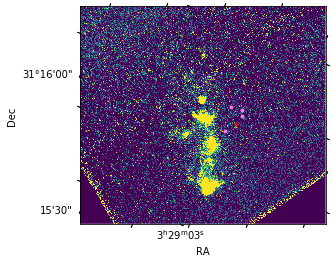

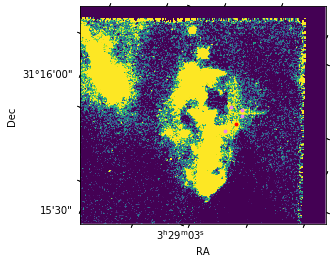

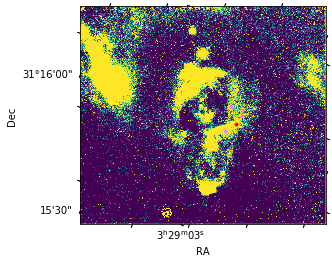

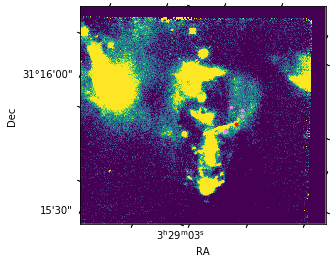

In [10]:
#the entire large region coordinates
cen_x = 690 # 580
cen_y = 440 # 370
del_x = 400 # 55
del_y = 300 #100

#trying to cut out the same region in all 4 images
# #HH9? The arcy feature thing
# cutout1 = Cutout2D(array2, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
# datacut1 = cutout1.data
# wcscut1 = cutout1.wcs 

# cutout2 = Cutout2D(hdu1_conv_scaled, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
# datacut2 = cutout2.data
# wcscut2 = cutout2.wcs 

# cutout3 = Cutout2D(array, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
# datacut3 = cutout3.data
# wcscut3 = cutout3.wcs 

# cutout4 = Cutout2D(array3, (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
# datacut4 = cutout4.data
# wcscut4 = cutout4.wcs 

#plotting cutouts for all wavelengths
msize = 8
implot(array2, w, True, np.mean(datacut1)) 
plt.scatter([690], [440], color = 'red', s=msize)
# plt.scatter([690+1], [440+1], color = 'violet', s=msize)
# plt.scatter([690-1], [440+1], color = 'violet', s=msize)
plt.scatter([690+25], [440+35], color = 'violet', s=msize)
plt.scatter([690-50], [440-30], color = 'violet', s=msize)
plt.scatter([690+25], [440+60], color = 'violet', s=msize)
plt.scatter([690-25], [440+75], color = 'violet', s=msize)

implot(hdu1_conv_scaled, w, True, np.mean(datacut2)) 
plt.scatter([690], [440], color = 'red', s=msize)
# plt.scatter([690+1], [440+1], color = 'violet', s=msize)
# plt.scatter([690-1], [440+1], color = 'violet', s=msize)
plt.scatter([690+25], [440+35], color = 'violet', s=msize)
plt.scatter([690-50], [440-30], color = 'violet', s=msize)
plt.scatter([690+25], [440+60], color = 'violet', s=msize)
plt.scatter([690-25], [440+75], color = 'violet', s=msize)

implot(array, w, True, np.mean(datacut3)) 
plt.scatter([690], [440], color = 'red', s=msize)
# plt.scatter([690+1], [440+1], color = 'violet', s=msize)
# plt.scatter([690-1], [440+1], color = 'violet', s=msize)
plt.scatter([690+25], [440+35], color = 'violet', s=msize)
plt.scatter([690-50], [440-30], color = 'violet', s=msize)
plt.scatter([690+25], [440+60], color = 'violet', s=msize)
plt.scatter([690-25], [440+75], color = 'violet', s=msize)

implot(array3, w, True, np.mean(datacut4)) 
plt.scatter([690], [440], color = 'red', s=msize)
# plt.scatter([690+1], [440+1], color = 'violet', s=msize)
# plt.scatter([690-1], [440+1], color = 'violet', s=msize)
plt.scatter([690+25], [440+35], color = 'violet', s=msize)
plt.scatter([690-50], [440-30], color = 'violet', s=msize)
plt.scatter([690+25], [440+60], color = 'violet', s=msize)
plt.scatter([690-25], [440+75], color = 'violet', s=msize)